In [36]:
import os
current_directory = os.getcwd() # 현재 작업 디렉토리를 얻기
print("현재 작업 디렉토리:", current_directory)

현재 작업 디렉토리: c:\apps\miniproj


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)


- 데이터 불러오고 탐색하기

In [38]:
df = pd.read_csv("./scaled_data.csv", index_col=0)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 0 to 207
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시점           208 non-null    int64  
 1   const        208 non-null    float64
 2   경제심리지수(원계열)  208 non-null    float64
 3   뉴스심리지수       208 non-null    float64
 4   원자재구입가격실적    208 non-null    float64
 5   달러결제수출비율     208 non-null    float64
 6   달러결제수입비율     208 non-null    float64
 7   달러결제순수입액     208 non-null    float64
 8   KO/US M2     208 non-null    float64
 9   BIRDIFF      208 non-null    float64
 10  TNDIFF       208 non-null    float64
 11  KO/US FER    208 non-null    float64
 12  KO/US PPI    208 non-null    float64
 13  KO/US SI     208 non-null    float64
 14  EIRDIFF      208 non-null    float64
 15  KRW/USD      208 non-null    float64
dtypes: float64(15), int64(1)
memory usage: 27.6 KB


In [40]:
Mdate = df['시점']
df.drop(['시점'], axis=1, inplace=True)

In [41]:
df

,const,경제심리지수(원계열),뉴스심리지수,원자재구입가격실적,달러결제수출비율,달러결제수입비율,달러결제순수입액,KO/US M2,BIRDIFF,TNDIFF,KO/US FER,KO/US PPI,KO/US SI,EIRDIFF,KRW/USD
0,1.0,95.3,106.39,0.25,0.823,0.779,-3319.3,148.557565,-1.000,-0.292,2.337711,1.035146,0.088914,1.5,1006.0
1,1.0,108.1,110.62,0.21,0.829,0.779,-2591.3,151.540035,-0.750,-0.503,2.533993,1.032485,0.093938,1.7,1015.5
2,1.0,110.9,103.98,0.24,0.820,0.789,-1680.5,150.138301,-0.500,-0.289,2.599641,1.019366,0.091937,1.5,997.1
3,1.0,110.4,100.87,0.26,0.825,0.786,-2170.7,151.788132,-0.500,-0.492,2.596480,1.013499,0.089409,1.5,1007.7
4,1.0,103.8,101.94,0.16,0.826,0.798,-2202.8,152.821713,-0.250,-0.439,2.641393,1.011457,0.092688,1.4,1025.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1.0,104.5,111.48,0.29,0.845,0.811,-1691.1,166.939423,-0.875,-0.677,1.840925,0.854696,0.081942,0.3,1205.5
204,1.0,105.7,103.28,0.34,0.838,0.845,4771.3,167.820811,-1.125,-0.715,1.849416,0.890439,0.075810,0.7,1202.3
205,1.0,105.8,103.65,0.35,0.845,0.816,-2086.5,169.448271,-1.125,-0.865,1.841966,0.884654,0.079639,1.0,1212.1
206,1.0,103.5,103.64,0.53,0.851,0.818,-2100.6,167.133457,-0.875,-0.446,1.853796,0.880099,0.079521,0.8,1255.9


- 데이터 탐색 공분산성 확인

<Axes: >

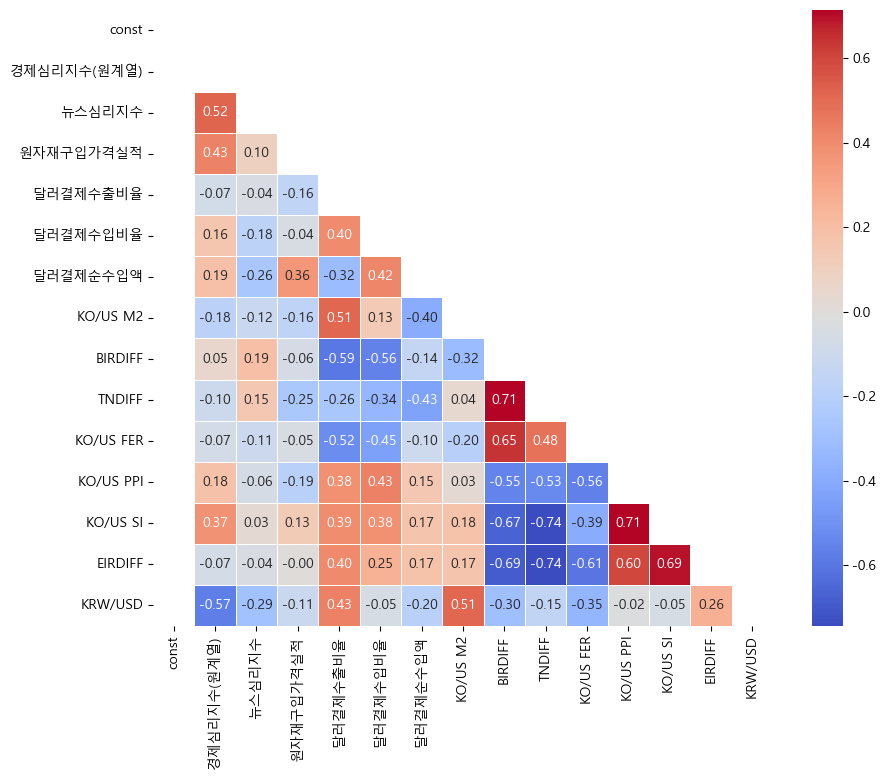

In [42]:
# 변수 다중공정성 보기  

corr_data = df[df.columns].corr()
plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_data, dtype=bool))

sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', mask=mask)

- 종속변수 인과관계 확인하기 

In [43]:
# 종속변수 인과관계 확인하기 
np.abs(corr_data.corr()['KRW/USD']).sort_values(ascending=False)

KRW/USD        1.000000
KO/US M2       0.812367
경제심리지수(원계열)    0.763509
달러결제수출비율       0.694314
뉴스심리지수         0.527624
BIRDIFF        0.507615
KO/US FER      0.495370
EIRDIFF        0.455036
원자재구입가격실적      0.365378
달러결제순수입액       0.313332
TNDIFF         0.275111
KO/US PPI      0.219014
달러결제수입비율       0.186930
KO/US SI       0.174125
const               NaN
Name: KRW/USD, dtype: float64

In [44]:
df.columns

Index(['const', '경제심리지수(원계열)', '뉴스심리지수', '원자재구입가격실적', '달러결제수출비율', '달러결제수입비율',
       '달러결제순수입액', 'KO/US M2', 'BIRDIFF', 'TNDIFF', 'KO/US FER', 'KO/US PPI',
       'KO/US SI', 'EIRDIFF', 'KRW/USD'],
      dtype='object')

- VIF 확인하기 

In [46]:
# VIF 확인하기 
X = df.drop(['KRW/USD'], axis=1)
# statsmodels의 상수항을 추가하기 위해 X에 상수 열 추가
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 결과 출력
vif.sort_values('VIF Factor',ascending=False)

,Feature,VIF Factor
0,const,13568.749891
12,KO/US SI,8.905967
9,TNDIFF,5.578752
8,BIRDIFF,5.304297
13,EIRDIFF,4.537066
11,KO/US PPI,4.321852
1,경제심리지수(원계열),3.828204
6,달러결제순수입액,3.790113
10,KO/US FER,3.738598
5,달러결제수입비율,3.192489


- OLS 정보 보기

In [47]:
# OLS 정보 보기 
# X = df[['위안화원_시', '유로달러_시', 'WTI','달러위안화_시','콜금리','달러엔_시']]
y = df[['KRW/USD']]
feature_add = sm.add_constant(X, has_constant='add')
# sm OLS 적합
model = sm.OLS(y , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                KRW/USD   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     36.02
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           1.02e-44
Time:                        16:56:51   Log-Likelihood:                -1120.6
No. Observations:                 208   AIC:                             2269.
Df Residuals:                     194   BIC:                             2316.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         345.8810    221.278      1.563      0.120     -90.538     782.300
const         345.8810    221.278      1.563      0.120     -90.538     782.300
경제심리지수(원계열)    -4.7339      0.707     -6.700      0.000      -6.127      -3.340
뉴스심리지수         -0.2081      0.591     -0.352      0.725      -1.373       0.957
원자재구입가격실적      32.6848     42.187      0.775      0.439     -50.520     115.890
달러결제수출비율     2313.2159    476.064      4.859      0.000    1374.290    3252.141
달러결제수입비율    -1489.8115    318.488     -4.678      0.000   -2117.956    -861.667
달러결제순수입액        0.0058      0.002      2.412      0.017       0.001       0.011
KO/US M2        3.5503      0.502      7.070      0.000       2.560       4.541
BIRDIFF        10.2666      6.772      1.516      0.131      -3.090      23.623
TNDIFF        -34.6336     11.363     -3.048      0.003     -57.044     -12.223
KO/US FER     -74.0558     13.516     -5.479      0.000    -100.714     -47.398
KO/US PPI    -216.3020    161.895     -1.336      0.183    -535.601     102.997
KO/US SI     -129.4394    401.487     -0.322      0.747    -921.278     662.400
EIRDIFF        -8.7614      3.781     -2.317      0.022     -16.219      -1.303
==============================================================================
Omnibus:                       61.393   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.901
Skew:                           1.150   Prob(JB):                     1.08e-48
Kurtosis:                       7.494   Cond. No.                     1.49e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.57e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- 변수 좁히기

In [50]:
X = X[['경제심리지수(원계열)', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액','KO/US M2', 'TNDIFF', 'KO/US FER', 'EIRDIFF']]

<Axes: >

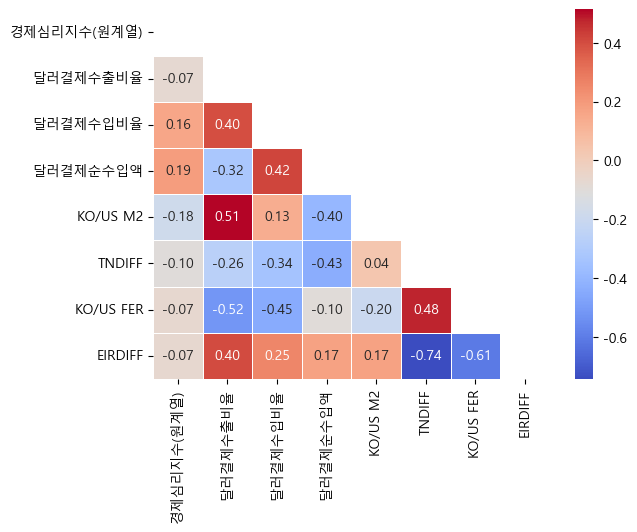

In [51]:
# 상관계수 표
corr_data = X[X.columns].corr()
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', mask=mask)

In [53]:
y.values.ravel()

array([1006. , 1015.5,  997.1, 1007.7, 1025.4, 1026.8, 1038.5, 1041.1,
       1040.2, 1033.5, 1011.6,  964.6,  970.9,  971.6,  943.4,  945.6,
        948.9,  955.2,  961.5,  946.2,  942.3,  929.5,  929.8,  941. ,
        941.8,  940.9,  930.8,  927.7,  923.8,  919.3,  938.3,  915.1,
        900.7,  921.1,  936.1,  943.9,  939. ,  990.4, 1002.6, 1030.1,
       1046. , 1012.2, 1089. , 1207. , 1291. , 1469. , 1259.5, 1379.5,
       1534. , 1383.5, 1282. , 1255. , 1273.9, 1228.5, 1248.9, 1178.1,
       1182.5, 1162.8, 1164.5, 1161.8, 1160. , 1131.3, 1108.4, 1202.5,
       1222.2, 1182.7, 1198.1, 1140.2, 1125.3, 1159.7, 1134.8, 1121.5,
       1128.7, 1096.7, 1071.5, 1079.2, 1067.7, 1054.5, 1066.8, 1178.1,
       1110. , 1143. , 1151.8, 1123.3, 1118.7, 1133. , 1130. , 1180.3,
       1145.4, 1130.6, 1134.7, 1111.4, 1090.7, 1082.9, 1070.6, 1089. ,
       1083. , 1111.1, 1101.2, 1129.7, 1142. , 1123.5, 1110. , 1074.7,
       1060.7, 1058.2, 1055.4, 1070.4, 1067.5, 1064.7, 1033.2, 1020.1,
      

- 종속변수와 산점도

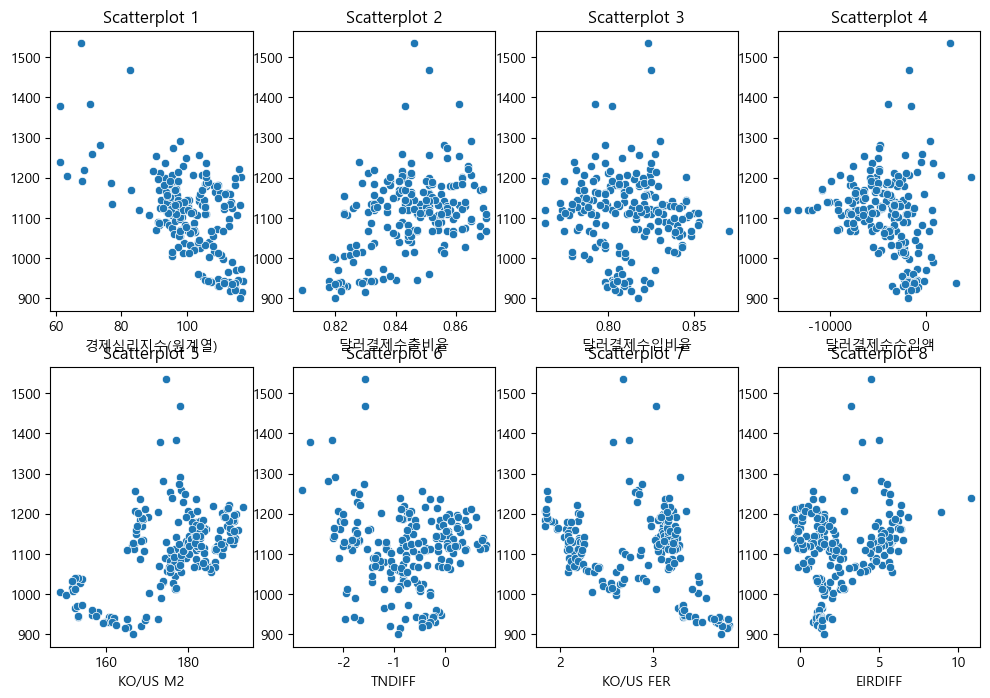

In [55]:
# 2x3 서브플롯 생성
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 8))
df1 = X

# 각 열에 대한 산점도 그리기
for i in range(nrows):
    for j in range(ncols):
        num = i * ncols + j
        sns.scatterplot(x=df1[df1.columns[num]], y=y.values.ravel(), ax=axs[i][j])
        axs[i][j].set_title(f"Scatterplot {num+1}")

- 독립변수끼리 산점도

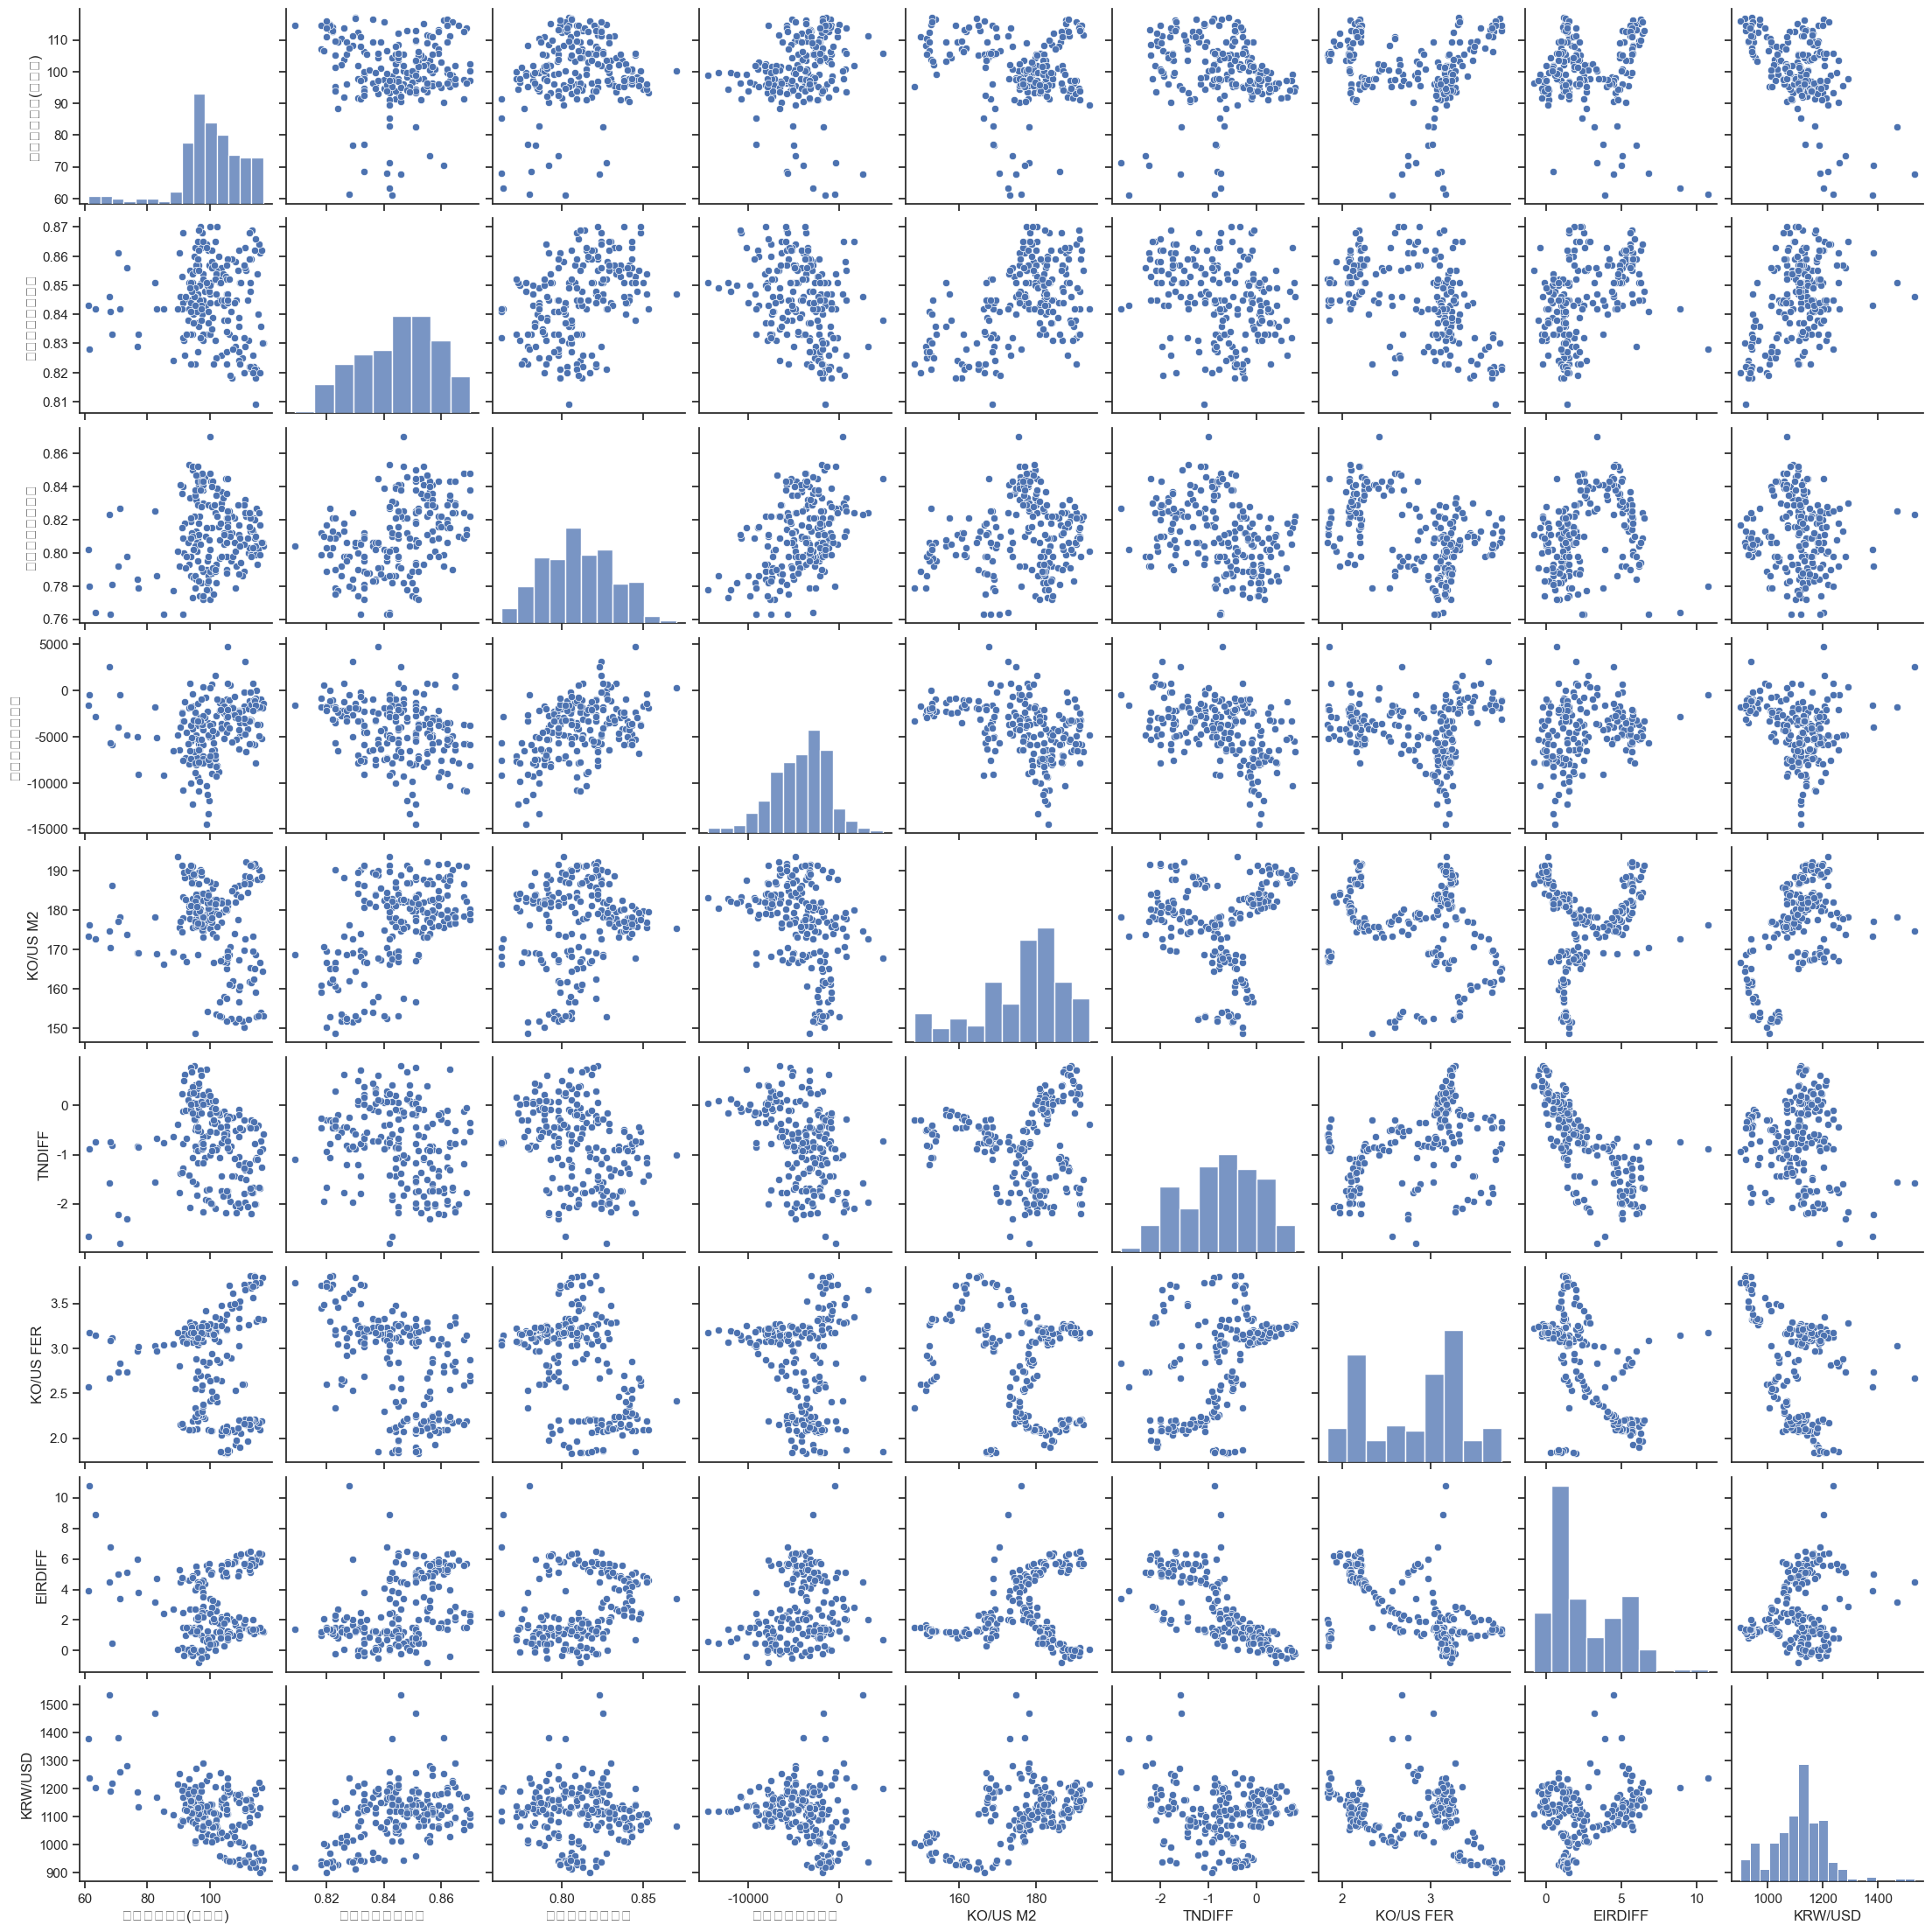

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# X는 독립 변수, y는 종속 변수로 설정해야 합니다.
# X = df[['경제심리지수(원계열)', '뉴스심리지수', '소비자심리지수', '원자재구입가격실적', '수출실적', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액', 'KO/US M2', 'BIRDIFF', 'TNDIFF']]
y = df['KRW/USD']

# 플롯을 그립니다.
sns.set(style="ticks")
sns.pairplot(pd.concat([X, y], axis=1))
plt.show()

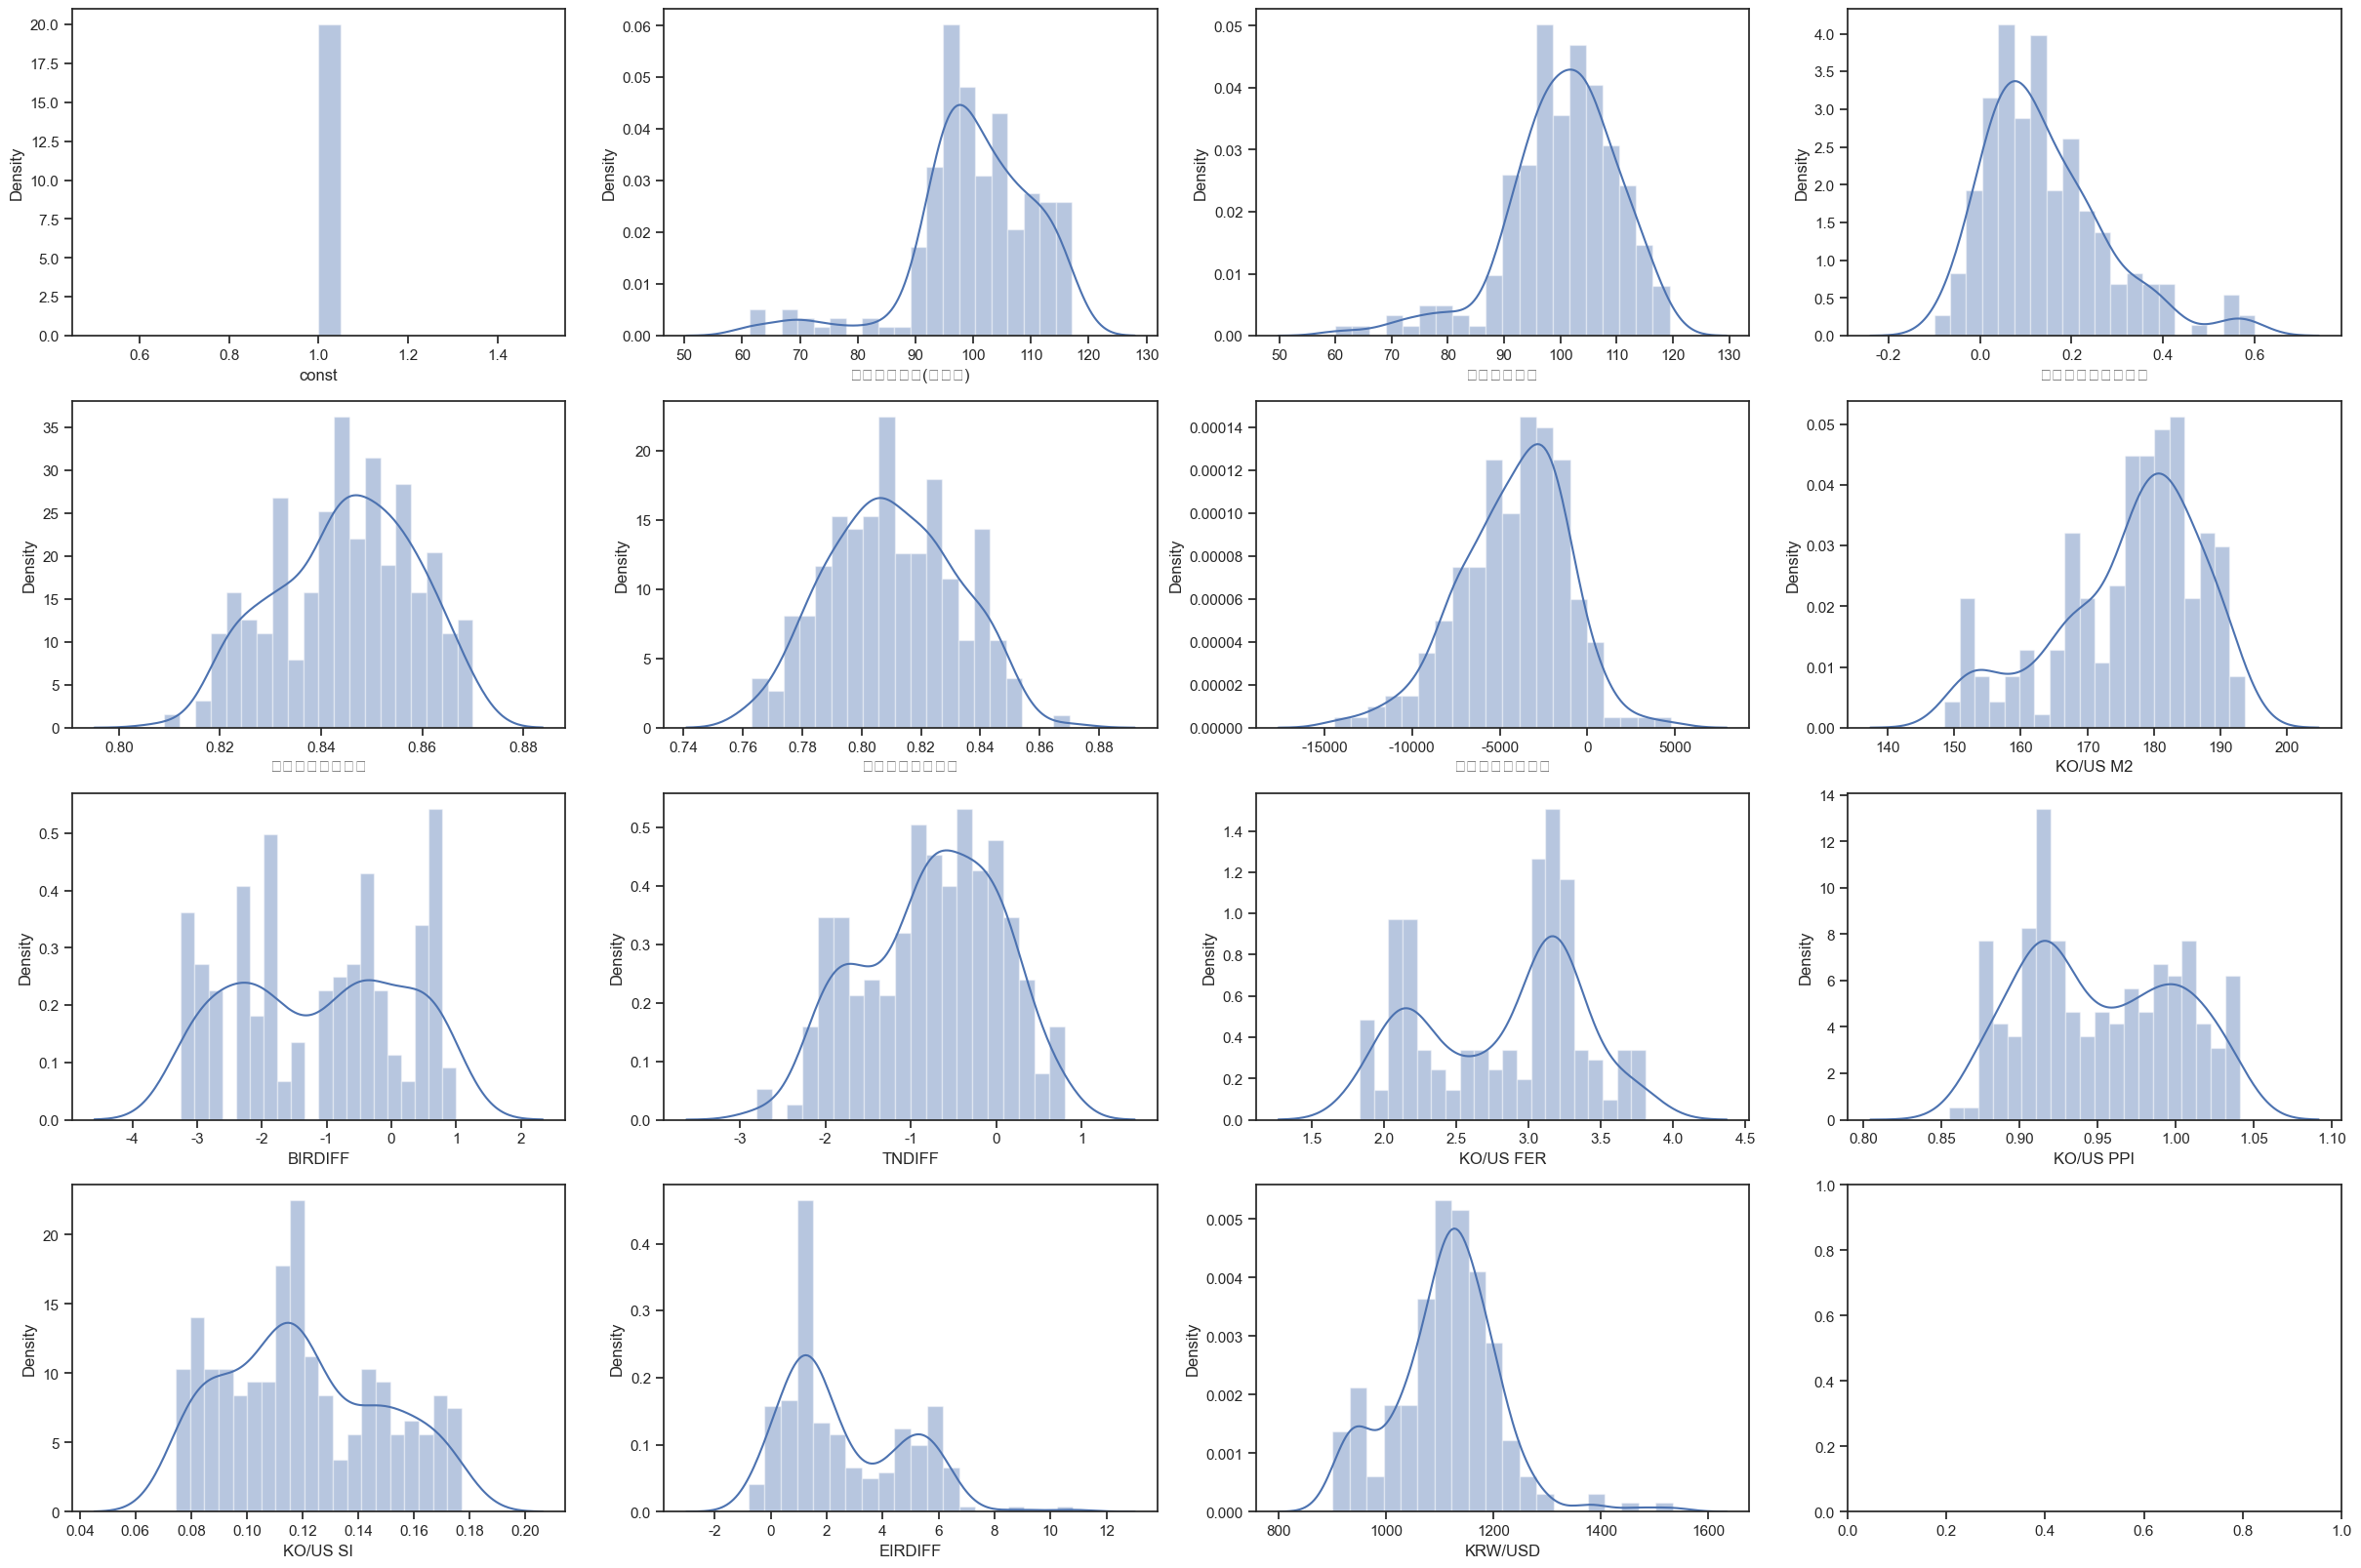

In [60]:
## histogram
col_n = 4
row_n = 4

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(30,row_n*5))

for i,col in enumerate(df.columns):
    sns.distplot(df[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])

- train_test_split

In [74]:
## 독립변수 선택 복습 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# df=pd.read_csv('../해커톤/Woo_data_3.csv',encoding='euc-kr',index_col=0)
# X=df.drop(['달러원종가','달러원시가'], axis=1)
# y=df[['달러원종가']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=42)

# RFE (Recursive Feature Elimination)

In [103]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
model = LinearRegression()

RFE = RFE(model, n_features_to_select=6) # 변수를 5개 선택
X_train_RFE = RFE.fit_transform(X_train,y_train)
X_test_RFE = RFE.transform(X_test)

In [104]:
X_train_RFE

array([[ 9.53000000e+01,  8.23000000e-01,  7.79000000e-01,
        -2.92000000e-01,  2.33771144e+00,  1.50000000e+00],
       [ 1.08100000e+02,  8.29000000e-01,  7.79000000e-01,
        -5.03000000e-01,  2.53399348e+00,  1.70000000e+00],
       [ 1.10900000e+02,  8.20000000e-01,  7.89000000e-01,
        -2.89000000e-01,  2.59964064e+00,  1.50000000e+00],
       [ 1.10400000e+02,  8.25000000e-01,  7.86000000e-01,
        -4.92000000e-01,  2.59647975e+00,  1.50000000e+00],
       [ 1.03800000e+02,  8.26000000e-01,  7.98000000e-01,
        -4.39000000e-01,  2.64139336e+00,  1.40000000e+00],
       [ 1.02100000e+02,  8.25000000e-01,  7.92000000e-01,
        -5.47000000e-01,  2.65835819e+00,  1.20000000e+00],
       [ 9.91000000e+01,  8.33000000e-01,  7.95000000e-01,
        -6.14000000e-01,  2.68560349e+00,  1.30000000e+00],
       [ 1.03300000e+02,  8.45000000e-01,  7.97000000e-01,
        -1.06600000e+00,  2.83968459e+00,  1.20000000e+00],
       [ 1.06700000e+02,  8.41000000e-01,  7.950

In [105]:
# feature 개수
RFE.n_features_in_

8

In [106]:
# feature들
RFE.feature_names_in_

array(['경제심리지수(원계열)', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액', 'KO/US M2',
       'TNDIFF', 'KO/US FER', 'EIRDIFF'], dtype=object)

In [107]:
# 우선순위
RFE.ranking_

array([1, 1, 1, 3, 2, 1, 1, 1])

In [108]:
# 우선순위가 1인 feature들
RFE.ranking_ ==1

array([ True,  True,  True, False, False,  True,  True,  True])

In [109]:
# 우선순위가 1인 feature들 선택
RFE.feature_names_in_[RFE.ranking_ ==1]   

array(['경제심리지수(원계열)', '달러결제수출비율', '달러결제수입비율', 'TNDIFF', 'KO/US FER',
       'EIRDIFF'], dtype=object)

# f_regression과 SelectKBest

In [179]:
## Filter 
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=4)
## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)
## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((166, 4), (42, 4))

In [180]:
selector.feature_names_in_

array(['경제심리지수(원계열)', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액', 'KO/US M2',
       'TNDIFF', 'KO/US FER', 'EIRDIFF'], dtype=object)

In [181]:
selector.get_support()

array([ True,  True, False, False,  True, False, False,  True])

In [182]:
selected_mask =selector.get_support()
selected_names = X.columns[selected_mask]
unselected_names = X.columns[~selected_mask]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['경제심리지수(원계열)', '달러결제수출비율', 'KO/US M2', 'EIRDIFF'], dtype='object')
Unselected names:  Index(['달러결제수입비율', '달러결제순수입액', 'TNDIFF', 'KO/US FER'], dtype='object')


In [183]:
## Embedded
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=RandomForestRegressor(), threshold=0.1).fit(X_train, y_train)
rf = selector.get_support()
count = np.count_nonzero(rf)
count


2

In [184]:
selector.get_support()

array([ True, False, False, False,  True, False, False, False])

In [185]:
selected_mask2=selector.get_support()

In [186]:
selected_names = X.columns[selected_mask2]
unselected_names = X.columns[~selected_mask2]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['경제심리지수(원계열)', 'KO/US M2'], dtype='object')
Unselected names:  Index(['달러결제수출비율', '달러결제수입비율', '달러결제순수입액', 'TNDIFF', 'KO/US FER', 'EIRDIFF'], dtype='object')


In [187]:
# Ridge 해보기 

# X = df[['위안화원_시', '유로달러_시', 'WTI','달러위안화_시','달러엔_시','콜금리']]
# y= df[['달러원종가']]

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 파이프라인 생성
pipeline = Pipeline([
    ('mm_scaler', MinMaxScaler()),  # 표준화
    ('ridge_reg', Ridge(alpha=1, solver="cholesky"))  # Ridge 회귀 모델
])

# 파이프라인 학습
pipeline.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = pipeline.predict(X_test) 
# 모델이 있어서 predict 한것 
# 스켈링만 있으면 trasform 한것 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score: {score:.2f}')



Mean Squared Error: 3793.59
Root Mean Squared Error: 61.59
r2_score: 0.55


In [188]:
from sklearn.model_selection import train_test_split

# X = df[['유로달러_시', 'WTI','달러위안화_시','달러엔_시','콜금리']]
# y= df[['달러원종가']]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=42) 


In [189]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

sclaer = MinMaxScaler()
lgb=LGBMRegressor()

pipe = Pipeline([
    ('scaler',sclaer),
    ('model', lgb)
])

param = {
    'model__max_depth': [2,3,5],
    'model__learning_rate' : [0.1,0.01]
}

grid = GridSearchCV(estimator=pipe, param_grid=param, cv=3)
grid.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275
[LightGBM] [Info] Number of data points in the train set: 110, number of used features: 8
[LightGBM] [Info] Start training from score 1118.388177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', LGBMRegressor())]),
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [2, 3, 5]})

In [190]:
grid.best_params_

{'model__learning_rate': 0.01, 'model__max_depth': 3}

In [191]:
y_pred=grid.predict(X_test)

In [192]:
y_pred

array([1134.4128401 , 1134.4128401 , 1120.42140962, 1103.22069686,
       1117.21212734, 1117.21212734, 1120.42140962, 1120.42140962,
       1120.42140962, 1120.42140962, 1134.4128401 , 1134.4128401 ,
       1120.42140962, 1105.15017755, 1103.22069686, 1114.91348868,
       1128.90491916, 1106.55162404, 1044.74750623, 1053.13512478,
       1053.13512478, 1053.13512478, 1053.13512478, 1053.13512478,
       1053.13512478, 1053.13512478, 1044.74750623, 1044.53946292,
       1052.92708148, 1044.53946292, 1044.74750623, 1053.13512478,
       1044.74750623, 1044.74750623, 1053.13512478, 1044.74750623,
       1044.74750623, 1044.74750623, 1044.74750623, 1044.74750623,
       1044.53946292, 1044.53946292])

In [193]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_pred,y_test)


print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score:{score:.2f}')

Mean Squared Error: 11073.49
Root Mean Squared Error: 105.23
r2_score:-7.44


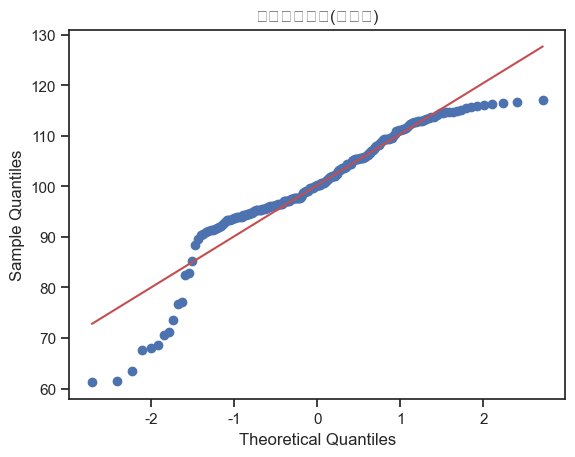

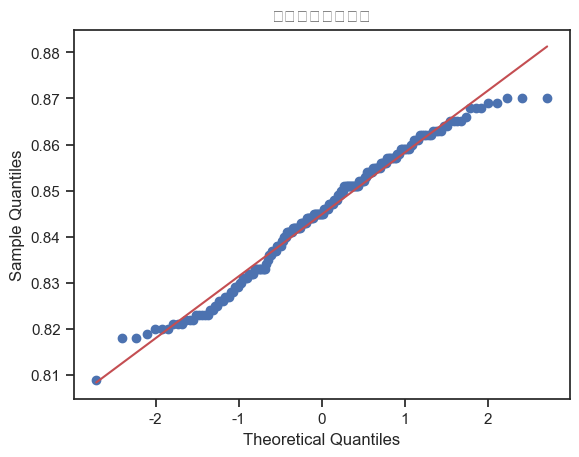

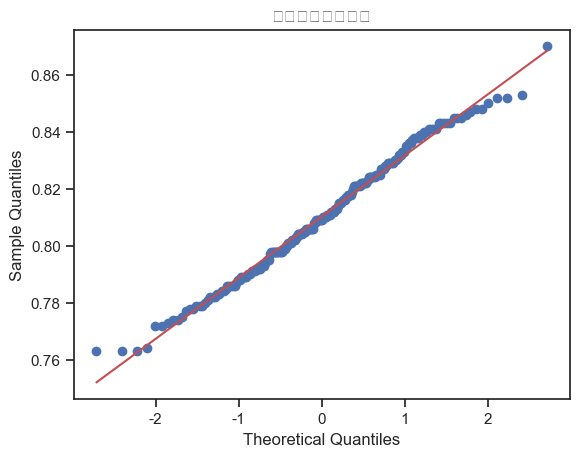

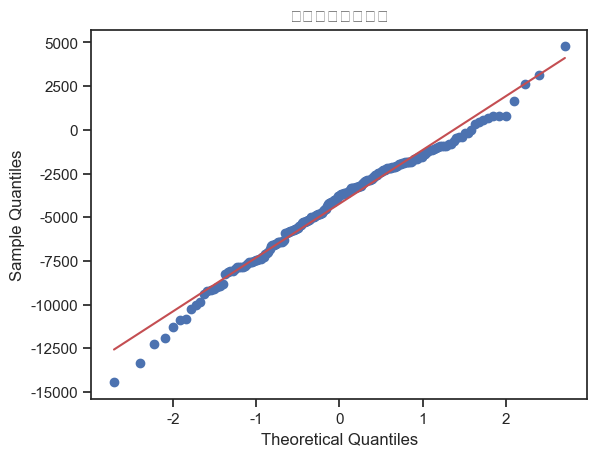

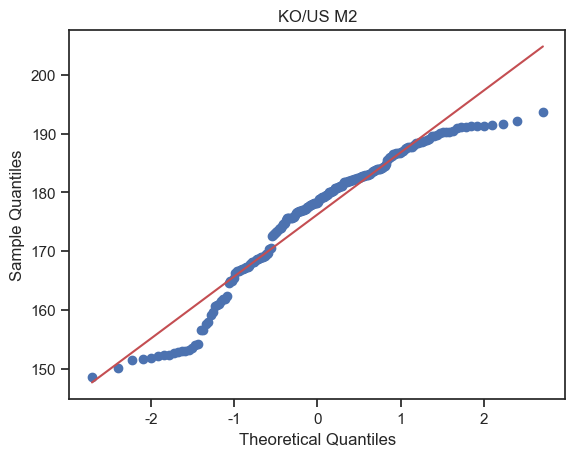

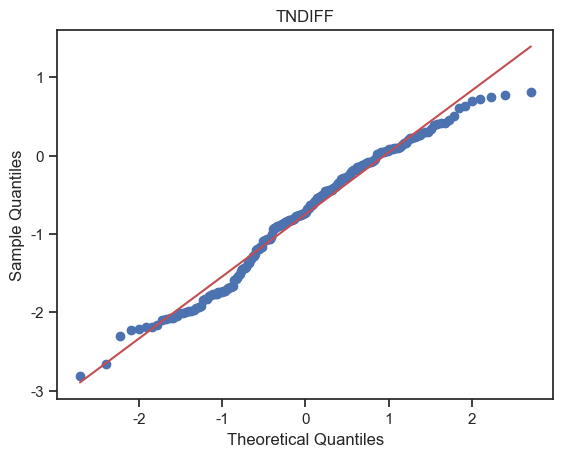

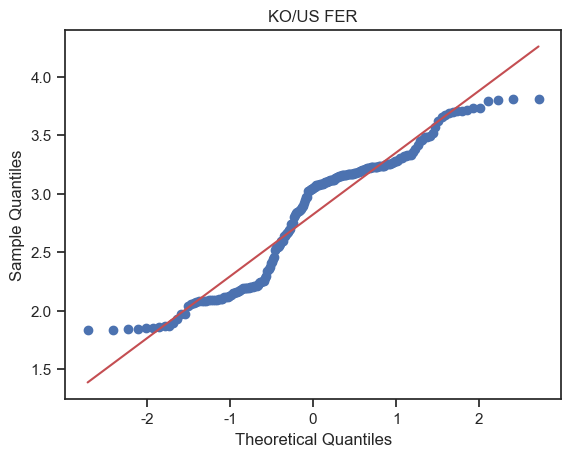

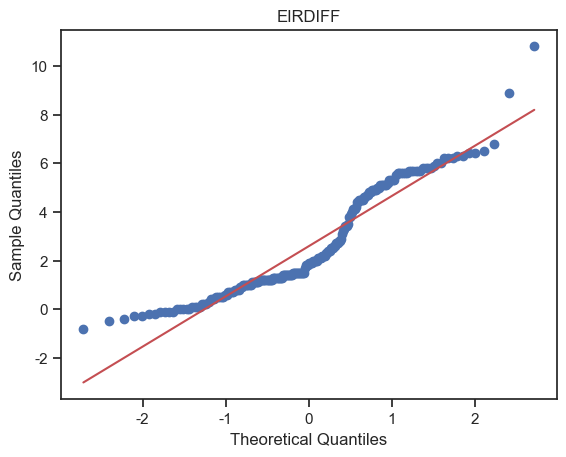

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 샘플 데이터 생성 (정규 분포를 따르지 않는 예제)
# np.random.seed(123)
# data = np.random.poisson(lam=2, size=100)  # 포아송 분포를 따르는 데이터 생성

# Q-Q plot 그리기
for i in range(len(X.columns)):
    stats.probplot(X[X.columns[i]], dist="norm", plot=plt)
    plt.title(X.columns[i])
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

In [195]:
X.columns

Index(['경제심리지수(원계열)', '달러결제수출비율', '달러결제수입비율', '달러결제순수입액', 'KO/US M2', 'TNDIFF',
       'KO/US FER', 'EIRDIFF'],
      dtype='object')